<a href="https://colab.research.google.com/github/KendallScott/Capstone_alt/blob/main/Data_Cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
https://geemap.org/notebooks/114_dynamic_world/


# Imports and Setup

In [3]:
!pip -q install --upgrade folium
!pip -q install geopandas
!pip -q install geojson
!pip -q install eeconvert

In [4]:
# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal

try:
    import geemap, ee
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
    import geemap, ee

In [5]:
pip install eemont

In [6]:
# Standard imports
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import folium
import eemont

import geopandas as gpd
from shapely.geometry import shape

### Mount Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Authenticate Google Earth Engine
Make sure you have signed up for access to Google Earth Engine at https://signup.earthengine.google.com/#!/. Once your request has been approved, you should be able to access Google Earth Engine at https://code.earthengine.google.com/.

In [8]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=7AYATCQ_MpfpEY_DId3H2eYhzEzRxQaj7qNvpz6jY7I&tc=6ZKiBQMvq_7gEXSqQQ9lfcL7IBWo4WWolnW_WNFkeZY&cc=IrtUSusXFMBTfJHVpF4YywCR5UuEdzODKd29-Y817p8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhWgUzwrhPgMWvGPtIG4fXt0AyvM7V5gJxujUiDI9IDeSHsaZYTa7GA

Successfully saved authorization token.


In [15]:
# Read the GeoJSON file
mines = gpd.read_file('/content/drive/MyDrive/OSMRE_GEOMINE_GEOJSON.geojson')


# Read data using GeoPandas
print("Data dimensions: {}".format(mines.shape))
mines.sample(3)

Data dimensions: (155, 31)


,id,Shape_Area,Shape_Le_1,area_mine,auger,calculated,coal_bed_n,coalmine_o,comment,company,...,permit_a_2,permit_app,permit_id,permittee,post_smcra,reported_a,shape_Leng,state_trib,steep_slop,geometry
105,0000000000000000007a,347217.026304,6414.684597,0,0,55.327247,,2,,ROYAL GEM COAL CO,...,NaN,0,81-113,ROYAL GEM COAL CO,1,0.0,6414.685279,,0,"MULTIPOLYGON (((-83.94485 36.50109, -83.94473 ..."
18,00000000000000000001,13303.969957,510.445336,0,0,2.145007,,2,,DALCO COAL OF TENNESSEE LLC,...,1.226650e+12,0,3049,DALCO COAL OF TENNESSEE LLC,1,0.0,510.445371,,0,"POLYGON ((-84.38151 36.03724, -84.38140 36.037..."
147,00000000000000000082,561884.429268,6190.027572,0,0,90.335545,,2,,INDUSTRIAL PROCESSING COMPANY,...,6.759324e+11,0,2782,INDUSTRIAL PROCESSING COMPANY,1,0.0,6190.027628,,0,"POLYGON ((-84.39592 36.14917, -84.39595 36.149..."


In [19]:
tn_mines = tn_mines.drop(columns=['permit_app'])
tn_mines = tn_mines.drop(columns=['permit_id'])
tn_mines = tn_mines.drop(columns=['permittee'])
tn_mines = tn_mines.drop(columns=['post_smcra'])
tn_mines = tn_mines.drop(columns=['reported_a'])
tn_mines = tn_mines.drop(columns=['state_trib'])
tn_mines = tn_mines.drop(columns=['shape_Leng'])
tn_mines = tn_mines.drop(columns=['steep_slop'])
tn_mines = tn_mines.drop(columns=['permit_a_2'])
tn_mines = tn_mines.drop(columns=['path'])
tn_mines = tn_mines.drop(columns=['comment'])
tn_mines = tn_mines.drop(columns=['coal_bed_n'])
tn_mines = tn_mines.drop(columns=['informatio'])
tn_mines = tn_mines.drop(columns=['layer'])

tn_mines = tn_mines.rename(columns={'id': 'shapeName'})

In [20]:
# Get the shape geometry for Tennesssee mines
region = eec.gdfToFc(tn_mines[0])

In [21]:
Map = geemap.Map()
Map.centerObject(region)

In [22]:
# Create Dynamic World land cover composite
# Set the date range
start_date = '2021-01-01'
end_date = '2022-01-01'

landcover = geemap.dynamic_world(region, start_date, end_date, return_type='hillshade')
Map.addLayer(landcover, {}, 'Land Cover')

In [23]:
# Visualize map
Map

Map(center=[35.925672500000005, -84.656623], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

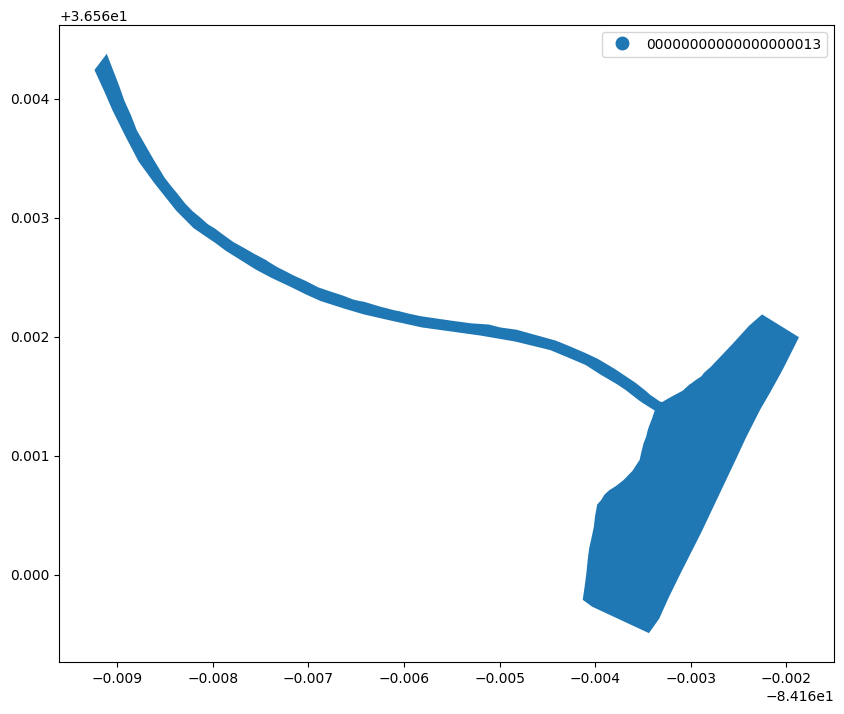

In [24]:
#example of Mine ID 00000000000000000013 shape
shape_name = '00000000000000000013'
fig, ax = plt.subplots(1, figsize=(10,10))
tn_mines[tn_mines.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

In [44]:
df = pd.DataFrame()

,id,longitude,latitude,time,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice,label
1,20210104T162701_20210104T162655_T16SGF,-84.313178,36.291039,1609778000459,0.04542,0.274786,0.092658,0.039822,0.038571,0.303898,0.032706,0.121162,0.034524,1
2,20210104T162701_20210104T162655_T17SKA,-84.313178,36.291039,1609777999068,0.042026,0.290325,0.087177,0.038763,0.04232,0.29151,0.03383,0.12493,0.034269,5
3,20210129T162529_20210129T163010_T16SGF,-84.313178,36.291039,1611937999778,0.046217,0.258137,0.105504,0.026195,0.042333,0.265838,0.038878,0.15122,0.041957,5
4,20210129T162529_20210129T163010_T17SKA,-84.313178,36.291039,1611937998386,0.042931,0.266436,0.109466,0.02528,0.046427,0.248172,0.035881,0.158534,0.039877,5


In [60]:
tn_mines_exploded=tn_mines.explode()
tn_mines_exploded

shapeName     Shape_Area   Shape_Le_1  area_mine  auger  \
0   0  0000000000000000000f  279564.400203  4225.466549          0      0   
    1  0000000000000000000f  279564.400203  4225.466549          0      0   
    2  0000000000000000000f  279564.400203  4225.466549          0      0   
2   0  0000000000000000002f   21783.670701  1152.399733          0      0   
    1  0000000000000000002f   21783.670701  1152.399733          0      0   
...                     ...            ...          ...        ...    ...   
144 1  00000000000000000020  755192.462987  5435.912214          0      0   
    2  00000000000000000020  755192.462987  5435.912214          0      0   
145 0  00000000000000000003  434590.221679  4235.327327          0      0   
    1  00000000000000000003  434590.221679  4235.327327          0      0   
    2  00000000000000000003  434590.221679  4235.327327          0      0   

       calculated  coalmine_o                    company  contact  contour  \
0   0   44.778976           2                 COALCO INC        4        0   
    1   44.778976           2                 COALCO INC        4        0   
    2   44.778976           2                 COALCO INC        4        0   
2   0    3.473654           2              DEBCO COAL CO        4        0   
    1    3.473654           2              DEBCO COAL CO        4        0   
...           ...         ...                        ...      ...      ...   
144 1  121.011095           2  NATIONAL COAL CORPORATION        4        0   
    2  121.011095           2  NATIONAL COAL CORPORATION        4        0   
145 0   69.636801           2               U S COAL INC        4        0   
    1   69.636801           2               U S COAL INC        4        0   
    2   69.636801           2               U S COAL INC        4        0   

       highwall  inspectabl                 mine_name  mountainto msha_id  \
0   0         0           2                                     0           
    1         0           2                                     0           
    2         0           2                                     0           
2   0         0           2                         1           0           
    1         0           2                         1           0           
...         ...         ...                       ...         ...     ...   
144 1         0           2  JORDAN RIDGE REFUSE AREA           0           
    2         0           2  JORDAN RIDGE REFUSE AREA           0           
145 0         0           2  JORDAN RIDGE REFUSE AREA           0           
    1         0           2  JORDAN RIDGE REFUSE AREA           0           
    2         0           2  JORDAN RIDGE REFUSE AREA           0           

      national_i   Latitude  Longitude  \
0   0   TN81-212  36.299869 -84.537769   
    1   TN81-212  36.299869 -84.537769   
    2   TN81-212  36.299869 -84.537769   
2   0   TN79-A10  36.476134 -84.278073   
    1   TN79-A10  36.476134 -84.278073   
...          ...        ...        ...   
144 1     TN3148  36.282867 -84.343683   
    2     TN3148  36.282867 -84.343683   
145 0     TN2788  36.283458 -84.345824   
    1     TN2788  36.283458 -84.345824   
    2     TN2788  36.283458 -84.345824   

                                                geometry  
0   0  POLYGON ((-84.53478 36.29566, -84.53472 36.295...  
    1  POLYGON ((-84.53583 36.29895, -84.53582 36.298...  
    2  POLYGON ((-84.54105 36.29877, -84.54100 36.298...  
2   0  POLYGON ((-84.27800 36.47555, -84.27799 36.475...  
    1  POLYGON ((-84.27972 36.47595, -84.27966 36.475...  
...                                                  ...  
144 1  POLYGON ((-84.34794 36.28202, -84.34793 36.282...  
    2  POLYGON ((-84.34803 36.28328, -84.34802 36.283...  
145 0  POLYGON ((-84.34968 36.28495, -84.34896 36.285...  
    1  POLYGON ((-84.34940 36.28312, -84.34939 36.283...  
    2  POLYGON ((-84.34860 36.28438, -84.34855 36.284...  

[113 rows x 19 co

In [77]:
i=0

# Initial date of interest (inclusive).
i_date = '2021-01-01'
# Final date of interest (exclusive).
f_date = '2021-01-15'

df_contructor = []
while i<=len(tn_mines_exploded):
 try:
        # Get dynamic world image collection by asset ID
        dc = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterBounds(region).filterDate(i_date, f_date)

        # get band names, equal to column names
        bandnames = dc.first().bandNames().getInfo()[:-1]

        polygon = tn_mines_exploded['geometry'].values[i]

        # Extract the coordinates from the polygon
        coordinates = polygon.exterior.coords[:]

        # Create an ee.Geometry object from the coordinates
        polygon = ee.Geometry.MultiPolygon(coordinates)

        # Set the maxError parameter
        max_error = 1  # Specify your desired maxError value

        # Project the geometry coordinates
        projected_polygon = polygon.transform('EPSG:4326', max_error)

        #decrease scale to get more rows of data/granularity
        ac = dc.getRegion(projected_polygon, scale=100 ).getInfo()
        df_constructor =pd.DataFrame(ac)

        df_constructor.columns = df_constructor.iloc[0]
        df_constructor = df_constructor.tail(-1)
        df_constructor['company'] = tn_mines_exploded['company'].values[i]
        df_constructor['shapeName'] = tn_mines_exploded['shapeName'].values[i]
        df_constructor['start_date'] = i_date
        df_constructor['end_Date'] = f_date
        df = df.append(df_constructor)

        print(tn_mines_exploded['company'].values[i])
        i+=1
 except:
          i+=1
          pass



COALCO INC
COALCO INC
COALCO INC
DEBCO COAL CO
DEBCO COAL CO
B + J EXCAVATING CO INC (TN)
B + J EXCAVATING CO INC (TN)
B + J EXCAVATING CO INC (TN)
WHITE OAK COAL CORP
WHITE OAK COAL CORP
WHITE OAK COAL CORP
WHITE OAK COAL CORP
PLYMOUTH COAL CO
PLYMOUTH COAL CO
S + H MINING INC
S + H MINING INC
HAMBLIN COAL CO
HAMBLIN COAL CO
HAMBLIN COAL CO
HAMBLIN COAL CO
HAMBLIN COAL CO
HAMBLIN COAL CO
SEQUATCHIE VALLEY COAL CORP
SEQUATCHIE VALLEY COAL CORP
TENNESSEE CONSOLIDATED COAL C0
TENNESSEE CONSOLIDATED COAL C0
ADDINGTON ENTERPRISES INC
ADDINGTON ENTERPRISES INC
ADDINGTON ENTERPRISES INC
ADDINGTON ENTERPRISES INC
ADDINGTON ENTERPRISES INC
LCC TENNESSEE  LLC
LCC TENNESSEE  LLC
LCC TENNESSEE  LLC
LCC TENNESSEE  LLC
LCC TENNESSEE  LLC
REX MINING INC
REX MINING INC
REX MINING INC
REX MINING INC
REX MINING INC
TRIPLE H COAL  LLC.
TRIPLE H COAL  LLC.
TRIPLE H COAL  LLC.
TRIPLE H COAL  LLC.
TRIPLE H COAL  LLC.
TENNESSEE MINING INC
TENNESSEE MINING INC
TENNESSEE MINING INC
TENNESSEE MINING INC
TENNES

In [78]:
df['company'].unique()

array([nan, 'COALCO INC', 'ENCOL INC', 'DEBCO COAL CO',
       'B + J EXCAVATING CO INC (TN)', 'CUMBERLAND COAL CO LLC',
       'PREMIUM COAL CO. INC', 'ROBINSON COAL CO',
       'SEQUATCHIE VALLEY COAL CORP', 'WHITE OAK COAL CORP',
       'COAL ENERGY INC', 'D + H COAL CO INC',
       'META ELKHORN MINING CO INC', 'ESTATE OF BRUNO GERNT INC',
       'KOPPER GLO FUEL INC', 'COLQUEST ENERGY INC',
       'EAST TENNESSEE RESOURCES INC', 'PLYMOUTH COAL CO',
       'S + H MINING INC', 'HAMBLIN COAL CO',
       'OLIVER SPRINGS MINING CO INC', 'TENNESSEE CONSOLIDATED COAL C0',
       'MARION COAL CO INC', 'PATTON MINING CO',
       'ADDINGTON ENTERPRISES INC', 'LCC TENNESSEE  LLC',
       'REX MINING INC', 'TRIPLE H COAL  LLC.', 'TENNESSEE MINING INC',
       'STONEY RIDGE COAL COMPANY INC', 'S R S COAL INC',
       'NATIONAL COAL CORPORATION', 'U S COAL INC', 'SHEMCO INC',
       'VOLUNTEER PROCESSING INC', 'MEADOWS COAL CO',
       'INDUSTRIAL PROCESSING COMPANY', 'ROBERT CLEAR COAL CORP',


In [79]:
df

,id,longitude,latitude,time,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice,label,company,shapeName
1,20210104T162701_20210104T162655_T16SGF,-84.313178,36.291039,1609778000459,0.04542,0.274786,0.092658,0.039822,0.038571,0.303898,0.032706,0.121162,0.034524,1,NaN,NaN
2,20210104T162701_20210104T162655_T17SKA,-84.313178,36.291039,1609777999068,0.042026,0.290325,0.087177,0.038763,0.04232,0.29151,0.03383,0.12493,0.034269,5,NaN,NaN
3,20210129T162529_20210129T163010_T16SGF,-84.313178,36.291039,1611937999778,0.046217,0.258137,0.105504,0.026195,0.042333,0.265838,0.038878,0.15122,0.041957,5,NaN,NaN
4,20210129T162529_20210129T163010_T17SKA,-84.313178,36.291039,1611937998386,0.042931,0.266436,0.109466,0.02528,0.046427,0.248172,0.035881,0.158534,0.039877,5,NaN,NaN
1,20210104T162701_20210104T162655_T16SGF,-84.539553,36.298226,1609778000459,0.050889,0.388929,0.057669,0.038968,0.028941,0.279445,0.027273,0.086808,0.031611,1,COALCO INC,0000000000000000000f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,20210104T162701_20210104T162655_T16SGF,-84.345068,36.2852,1609778000459,0.069676,0.498362,0.074818,0.040029,0.038362,0.145228,0.039846,0.053292,0.03785,1,U S COAL INC,00000000000000000003
30,20210104T162701_20210104T162655_T16SGF,-84.344169,36.2852,1609778000459,0.069764,0.354117,0.079024,0.039367,0.043649,0.254445,0.040096,0.069402,0.044334,1,U S COAL INC,00000000000000000003
31,20210104T162701_20210104T162655_T16SGF,-84.345966,36.286098,1609778000459,0.055175,0.222323,0.069861,0.037601,0.052108,0.207541,0.224025,0.066515,0.042887,6,U S COAL INC,00000000000000000003
32,20210104T162701_20210104T162655_T16SGF,-84.345068,36.286098,1609778000459,0.069354,0.358745,0.090561,0.045413,0.046053,0.223375,0.054247,0.065136,0.039227,1,U S COAL INC,00000000000000000003


In [81]:
len(df['company'].unique())

48

In [80]:
len(tn_mines['company'].unique())

27